# **Modeling and Evaluation Notebook**

## Overall Insights for MobileNetV2 ver.1

- Exceptional Test Performance: The model achieves 100% accuracy on the test set, demonstrating strong classification ability.
- Training Concerns: The training accuracy and AUC suggest limited learning on training data, potentially leading to overfitting to validation data.
- Deployment Readiness: While the model performs flawlessly on the test set, further validation on new data is necessary to confirm real-world robustness.

---

# Set Data Directory

---

## Import Necessary Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir("/workspaces/mildew-detector")
print("You set a new current directory")

You set a new current directory


#### Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew-detector'

## Set Input Directories

In [5]:
# Set input directories
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

## Set Output Directory

In [6]:
version = "v1"
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set Label Names

In [7]:
# Set the labels for the images
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['Healthy', 'Infected']


## Set Image Shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(128, 128, 3)

---

## Number of Images in Train, Test and Validation Data

In [9]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define dataset folders
folders = ['train', 'validation', 'test']

# Loop through each dataset split and count images
for folder in folders:
    for label in labels:
        path = os.path.join(my_data_dir, folder, label)
        num_images = len(os.listdir(path)) if os.path.exists(path) else 0  
        data['Set'].append(folder)
        data['Label'].append(label)
        data['Frequency'].append(num_images)
        print(f" {folder}/{label}: {num_images} images")

# Convert dictionary to DataFrame
df_freq = pd.DataFrame(data)

 train/Healthy: 1472 images
 train/Infected: 1472 images
 validation/Healthy: 210 images
 validation/Infected: 210 images
 test/Healthy: 422 images
 test/Infected: 422 images


### Bar Chart - Image Distribution

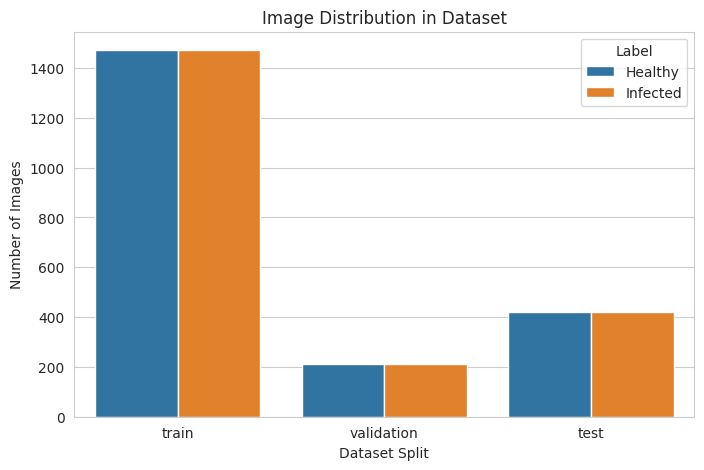

In [10]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution in Dataset")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Implement Data Augmentation

---

### ImageDataGenerator

In [11]:
# Import TensorFlow/Keras ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-03-08 00:19:53.940157: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-08 00:19:53.973726: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Augment Training, Validation, and Test Sets

- Initialize ImageDataGenerator for Data Augmentation

In [12]:
# Define Augmentation for Training Set
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

- Augment Training Image Dataset

In [13]:
batch_size = 16  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Validation Image Dataset

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Test Image Dataset

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

---

## Visualization of Augmented Images

### Plot Augmented Training Image

(16, 128, 128, 3)


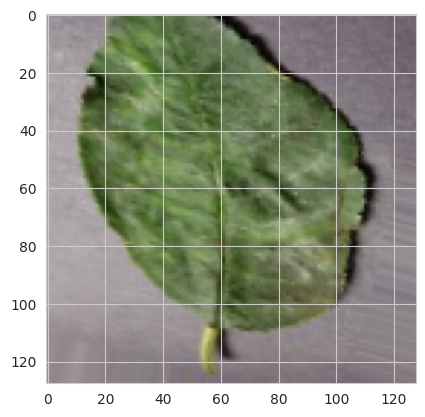

(16, 128, 128, 3)


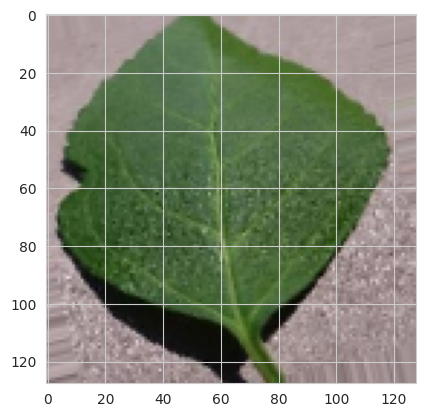

(16, 128, 128, 3)


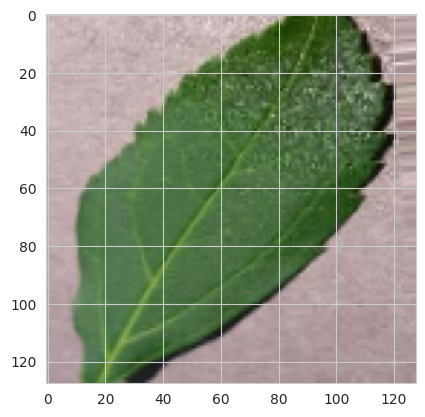

In [16]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot Augmented Validation and Test Images

(16, 128, 128, 3)


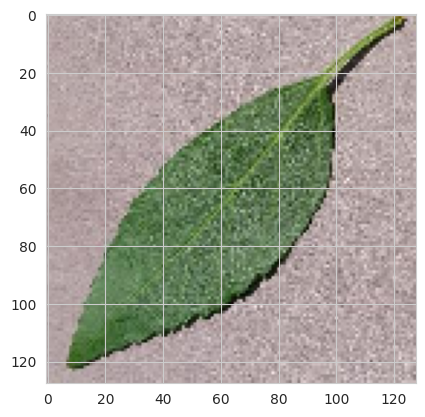

(16, 128, 128, 3)


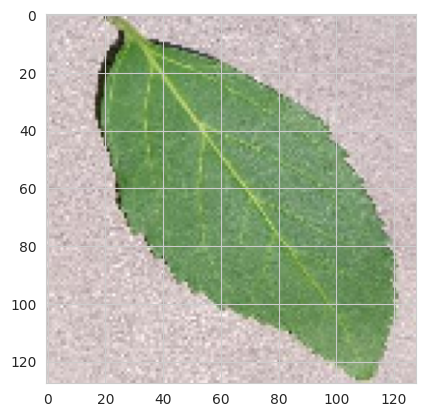

(16, 128, 128, 3)


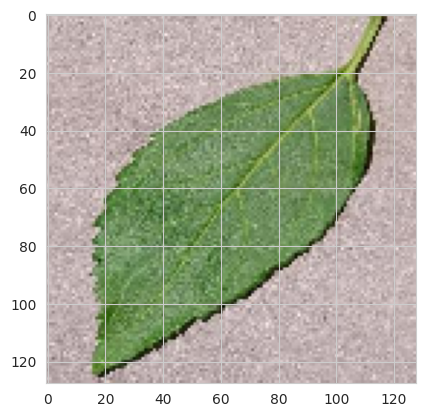

In [17]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(16, 128, 128, 3)


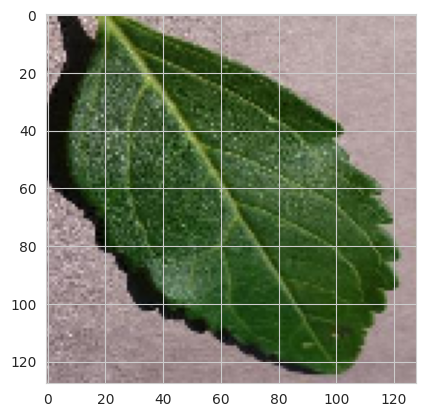

(16, 128, 128, 3)


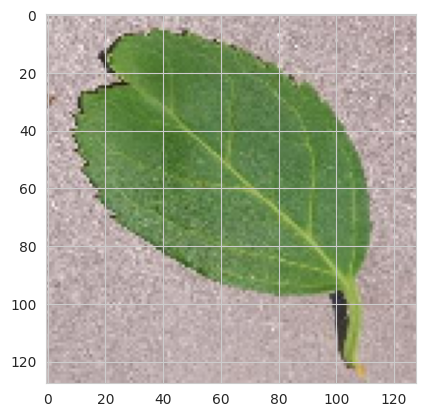

(16, 128, 128, 3)


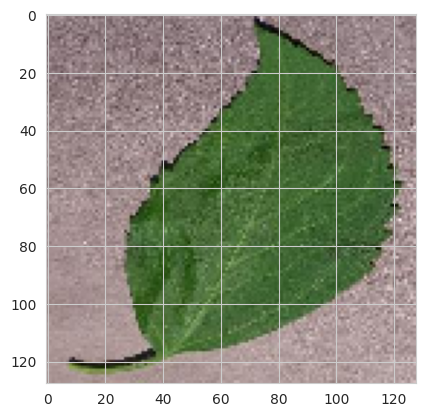

In [18]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save Class Indices

In [19]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

### Compare Multiple Augmented Images in a Grid

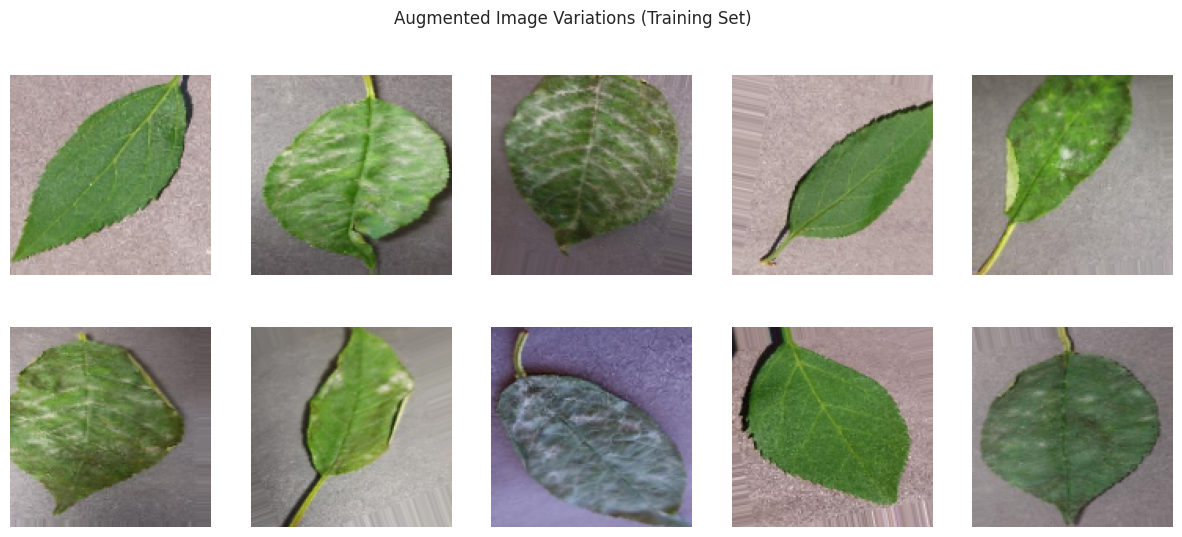

In [20]:
def plot_augmented_images_grid(data_generator, num_images=10):
    """Displays a grid of augmented images to visualize transformation effects."""
    img_batch, label_batch = next(data_generator)

    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 6))
    
    for i in range(num_images):
        ax = axes[i // (num_images // 2), i % (num_images // 2)]
        ax.imshow(img_batch[i])
        ax.axis("off")

    plt.suptitle("Augmented Image Variations (Training Set)")
    plt.show()

# Display the augmented image grid
plot_augmented_images_grid(train_set)

---

# Model Creation

---

### Import Libraries

In [21]:
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

## MobileNetV2

MobileNetV2 was explored due to its efficient architecture, strong feature extraction capabilities, and ability to maintain high accuracy with fewer parameters. Its lightweight design makes it well-suited for deployment in resource-constrained environments.

In [22]:
# Define hyperparameter
learning_rate = 0.0001
l2_lambda = 0.002
dropout_rate = 0.5
activation_function = "relu"
patience_value = 5

# Create MobileNetV2 Model 
model_mobilenet = Sequential(
    [
        MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3)),
        GlobalAveragePooling2D(),
        Dense(128, activation=activation_function, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(2, activation="softmax"),
    ]
)

# Compile Model
model_mobilenet.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Model Summary

In [23]:
# Print Model Summary
model_mobilenet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 2,388,098 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

---

## Model Training

### Start Training Timer

In [24]:
import time
import pandas as pd

# Start time tracking
start_time = time.time()

### Early Stopping Implementation

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_value, restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", mode="min", factor=0.5, patience=2, min_lr=1e-6
)


### Fit Model for Training

In [26]:
# Train the Model
history_mobilenet = model_mobilenet.fit(
    train_set,
    epochs=10,
    steps_per_epoch=len(train_set.classes) // batch_size,
    validation_data=validation_set,
    callbacks=[early_stop, lr_scheduler],
    verbose=1,
)

Epoch 1/10


/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 115s 506ms/step - accuracy: 0.8878 - loss: 0.7421 - val_accuracy: 0.6143 - val_loss: 1.6749 - learning_rate: 1.0000e-04
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 99s 539ms/step - accuracy: 0.9951 - loss: 0.4457 - val_accuracy: 0.8262 - val_loss: 0.9224 - learning_rate: 1.0000e-04
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 140s 526ms/step - accuracy: 0.9979 - loss: 0.3982 - val_accuracy: 0.8405 - val_loss: 0.9566 - learning_rate: 1.0000e-04
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 136s 493ms/step - accuracy: 0.9995 - loss: 0.3595 - val_accuracy: 0.9119 - val_loss: 0.6969 - learning_rate: 1.0000e-04
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 139s 477ms/step - accuracy: 0.9988 - loss: 0.3264 - val_accuracy: 0.9524 - val_loss: 0.5036 - learning_rate: 1.0000e-04
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 96s 519ms/step - accuracy: 0.9986 - loss: 0.3007 - val_accuracy: 0.9905 - val_loss: 0.2979 - learning_rate: 1.0000e-04
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 145s 539ms/st

### Save Model

In [27]:
model_mobilenet.save("outputs/v1/mobilenet.h5")

---

# Model Performance

---

## Learning Curves 

In [28]:
import plotly.express as px
import matplotlib.pyplot as plt

output_dir = "outputs/v1"

# Extract history from the training process
history_dict = history_mobilenet.history

# Convert history dictionary to a long format for Plotly
df_long = pd.DataFrame({
    'Epoch': range(1, len(history_dict['loss']) + 1),
    'loss': history_dict['loss'],
    'val_loss': history_dict['val_loss'],
    'accuracy': history_dict['accuracy'],
    'val_accuracy': history_dict['val_accuracy']
})

# Convert to long format
df_long = df_long.melt(id_vars=["Epoch"], value_vars=["loss", "val_loss", "accuracy", "val_accuracy"],
                       var_name="Metric", value_name="Value")

# Split into two DataFrames: one for loss, one for accuracy
df_loss = df_long[df_long["Metric"].isin(["loss", "val_loss"])]
df_acc = df_long[df_long["Metric"].isin(["accuracy", "val_accuracy"])]

# Interactive Loss Curve
fig_loss = px.line(
    df_loss,
    x="Epoch",
    y="Value",
    color="Metric",
    markers=True,
    title="Loss - MobileNetV2",
    labels={"Value": "Loss", "Epoch": "Epoch"},
    template="plotly_white",
)

# Interactive Accuracy Curve
fig_acc = px.line(
    df_acc,
    x="Epoch",
    y="Value",
    color="Metric",
    markers=True,
    title="Accuracy - MobileNetV2",
    labels={"Value": "Accuracy", "Epoch": "Epoch"},
    template="plotly_white",
)

# Save the figures as static PNGs
fig_loss.write_image(f"{output_dir}/model_training_losses.png", scale=2)
fig_acc.write_image(f"{output_dir}/model_training_acc.png", scale=2)

# Show interactive plots
fig_loss.show()
fig_acc.show()

## Learning Curve Insights	
  
- Accuracy Trend: The model reaches near-perfect accuracy on both training and validation sets, suggesting strong predictive capability.
- Loss Convergence: The loss steadily decreases, with minimal divergence between training and validation loss, indicating effective learning without overfitting.

---

# Model Evaluation

### Import Packages

In [29]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
)

### Load Saved Model

In [30]:
from keras.models import load_model

# Load the model
model_mobilenet = load_model("outputs/v1/mobilenet.h5")

## Evaluation on Test Set

In [31]:
evaluation = model_mobilenet.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ", evaluation[0])

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 1.0000 - loss: 0.1779
Model accuracy: 100.00%
Model Loss:  0.17824901640415192


## Set Accuracy Variables

In [32]:
# Correctly obtain true labels
y_true = test_set.labels

# Obtain model predictions
preds = model_mobilenet.predict(test_set)
y_pred = np.argmax(preds, axis=1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step


## Histograms

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step 


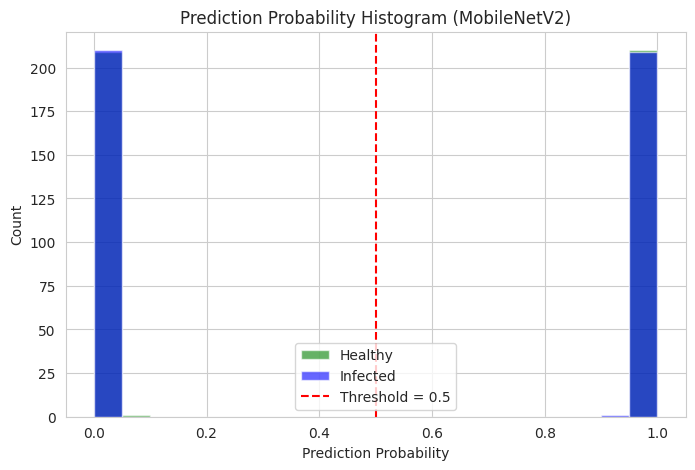

Histogram saved at: outputs/v1/histogram_test.png


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
output_dir = "outputs/v1"
os.makedirs(output_dir, exist_ok=True)

# Get predicted probabilities
y_pred_probs = model_mobilenet.predict(validation_set)

# Extract class probabilities
healthy_probs = y_pred_probs[:, 0]  # Probability of Healthy class
infected_probs = y_pred_probs[:, 1]  # Probability of Infected class

# Create static histogram using Matplotlib
plt.figure(figsize=(8, 5))
plt.hist(healthy_probs, bins=20, alpha=0.6, color="green", label="Healthy")
plt.hist(infected_probs, bins=20, alpha=0.6, color="blue", label="Infected")

# Add threshold line at 0.5
plt.axvline(x=0.5, color="red", linestyle="dashed", label="Threshold = 0.5")

# Labels and Title
plt.title("Prediction Probability Histogram (MobileNetV2)")
plt.xlabel("Prediction Probability")
plt.ylabel("Count")
plt.legend()
plt.grid(True)

# Define file path
histogram_path = os.path.join(output_dir, "histogram_test.png")

# Save the figure as a static PNG
plt.savefig(histogram_path, dpi=150, bbox_inches="tight")

# Show the static histogram in the notebook
plt.show()

print(f"Histogram saved at: {histogram_path}")

## Histogram Insights

- Confident Predictions: The model predicts probabilities close to 0 or 1, showing high certainty in its classifications.
- Threshold Alignment: Most predictions align well with the 0.5 threshold, reinforcing clear class separation.

## Confusion Matrix

184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step


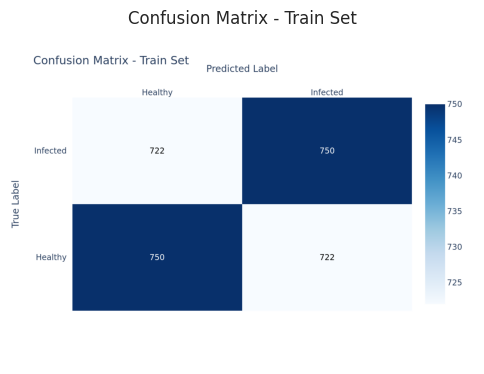

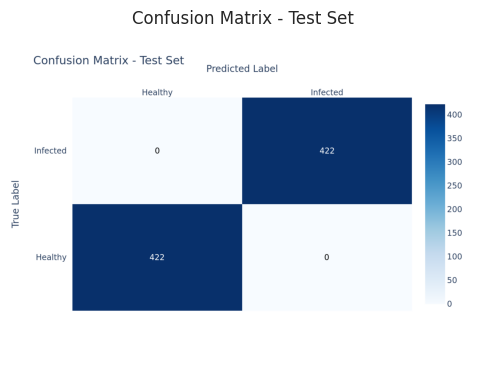

Confusion Matrices saved at: outputs/v1/confusion_matrix_train.png & outputs/v1/confusion_matrix_test.png


In [34]:
import numpy as np
import os
import pandas as pd
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure output directory exists
output_dir = "outputs/v1"
os.makedirs(output_dir, exist_ok=True)

# Get Class Labels
label_map = list(test_set.class_indices.keys())

# Evaluate Model on Train and Test Sets
y_true_train = train_set.classes
y_pred_train = np.argmax(model_mobilenet.predict(train_set), axis=1)

y_true_test = test_set.classes
y_pred_test = np.argmax(model_mobilenet.predict(test_set), axis=1)

# Generate Confusion Matrices for Train and Test Sets
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Convert confusion matrices to DataFrames
df_cm_train = pd.DataFrame(cm_train, index=label_map, columns=label_map)
df_cm_test = pd.DataFrame(cm_test, index=label_map, columns=label_map)


# Function to create interactive Confusion Matrix
def create_confusion_matrix_figure(conf_matrix, title):
    fig = ff.create_annotated_heatmap(
        z=conf_matrix.values,
        x=conf_matrix.columns.tolist(),
        y=conf_matrix.index.tolist(),
        colorscale="Blues",
        showscale=True,
    )

    fig.update_layout(
        title=title,
        xaxis_title="Predicted Label",
        yaxis_title="True Label",
        template="plotly_white",
    )
    return fig


# Create interactive plots for both train and test sets
fig_train = create_confusion_matrix_figure(df_cm_train, "Confusion Matrix - Train Set")
fig_test = create_confusion_matrix_figure(df_cm_test, "Confusion Matrix - Test Set")

# Define file paths
train_cm_path = os.path.join(output_dir, "confusion_matrix_train.png")
test_cm_path = os.path.join(output_dir, "confusion_matrix_test.png")

# Save Figures as Static PNGs
fig_train.write_image(train_cm_path, scale=2)
fig_test.write_image(test_cm_path, scale=2)

# Show interactive Confusion Matrices in the notebook
fig_train.show()
fig_test.show()

# Display the saved static Confusion Matrices using Matplotlib
for path, title in zip([train_cm_path, test_cm_path], ["Train Set", "Test Set"]):
    img = plt.imread(path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

print(f"Confusion Matrices saved at: {train_cm_path} & {test_cm_path}")

## Confusion Matrix Insights

- Train Set: The model exhibits moderate classification balance, with some misclassifications suggesting potential issues in capturing class distinctions.
- Test Set: The model perfectly classifies all test samples, achieving 100% accuracy, which could indicate overfitting to the training data.

## Classification Reports

In [35]:
from sklearn.metrics import classification_report
import os

output_dir = "outputs/v1"

# Generate classification reports as text
report_train = classification_report(
    y_true_train, y_pred_train, target_names=label_map, digits=3
)
report_test = classification_report(
    y_true_test, y_pred_test, target_names=label_map, digits=3
)

# Print Train Report
print("\n### Classification Report - Train Set ###\n")
print(report_train)

# Print Test Report
print("\n### Classification Report - Test Set ###\n")
print(report_test)

# Save reports as text files
with open(f"{output_dir}/classification_report_train.txt", "w") as f:
    f.write(report_train)

with open(f"{output_dir}/classification_report_test.txt", "w") as f:
    f.write(report_test)

print("\nReports saved to outputs/v1/")


### Classification Report - Train Set ###

              precision    recall  f1-score   support

     Healthy      0.510     0.510     0.510      1472
    Infected      0.510     0.510     0.510      1472

    accuracy                          0.510      2944
   macro avg      0.510     0.510     0.510      2944
weighted avg      0.510     0.510     0.510      2944


### Classification Report - Test Set ###

              precision    recall  f1-score   support

     Healthy      1.000     1.000     1.000       422
    Infected      1.000     1.000     1.000       422

    accuracy                          1.000       844
   macro avg      1.000     1.000     1.000       844
weighted avg      1.000     1.000     1.000       844


Reports saved to outputs/v1/


## Classification Report Insights

**Test Set Performance**:
- Perfect Scores (Precision, Recall, F1-Score = 1.000): The model perfectly classifies all test samples.
- High Generalization Ability: No misclassified test samples indicate robust real-world applicability.
**Train Set Performance**:
- Lower Accuracy (51%): Unlike the test set, the training data shows weaker performance, suggesting imbalanced learning.
- Equal Precision & Recall (0.510): The model struggles with both classes equally, pointing to potential underfitting or training inefficiencies.

## ROC Curves

184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 131ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step


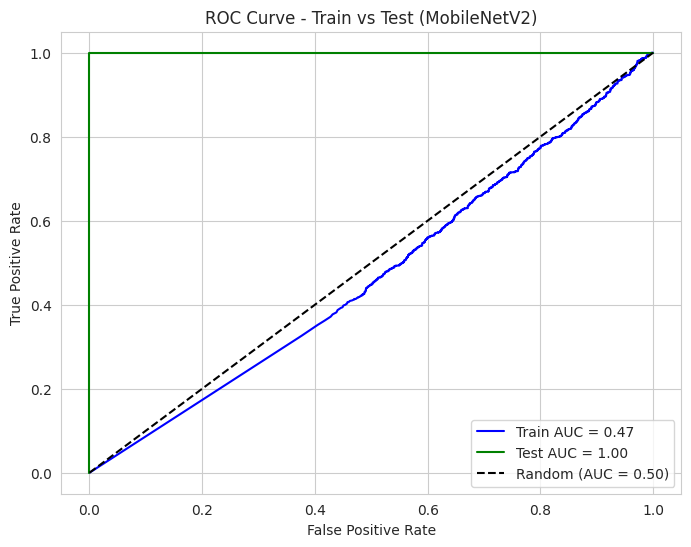

ROC Curve saved at: outputs/v1/roc_curve.png


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os

# Ensure output directory exists
output_dir = "outputs/v1"
os.makedirs(output_dir, exist_ok=True)

# Generate predictions (probabilities) for both train and test sets
y_probs_train = model_mobilenet.predict(train_set)
y_probs_test = model_mobilenet.predict(test_set)

# Compute ROC curve for train and test sets
fpr_train, tpr_train, _ = roc_curve(
    y_true_train, y_probs_train[:, 1]
)  # Use class 1 probability
fpr_test, tpr_test, _ = roc_curve(
    y_true_test, y_probs_test[:, 1]
)  # Use class 1 probability

# Compute AUC for train and test sets
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Create static ROC curve using Matplotlib
plt.figure(figsize=(8, 6))

# Plot Train ROC
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.2f}", color="blue")

# Plot Test ROC
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.2f}", color="green")

# Plot Random Guess Line (Baseline)
plt.plot([0, 1], [0, 1], linestyle="dashed", color="black", label="Random (AUC = 0.50)")

# Labels and Title
plt.title("ROC Curve - Train vs Test (MobileNetV2)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Define file path
roc_curve_path = os.path.join(output_dir, "roc_curve.png")

# Save the figure as a static PNG
plt.savefig(roc_curve_path, dpi=150, bbox_inches="tight")

# Show the static ROC curve in the notebook
plt.show()

print(f"ROC Curve saved at: {roc_curve_path}")

## ROC Curve Insights

- Test AUC = 1.00: The model achieves perfect discrimination on the test set, indicating ideal generalization.
- Train AUC = 0.47: The low training AUC suggests poor learning on training data, potentially due to underfitting or class imbalance.
- Gap Between Train & Test: The disparity raises concerns about whether the model is too tuned to the test data, requiring further evaluation.

## Save Evaluation Pickle

In [37]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Business Goal Validation

In [38]:
# Load evaluation results
evaluation_results = joblib.load("outputs/v1/evaluation.pkl")

# Extract final test accuracy
test_accuracy = evaluation_results[1]  # Since the second item is likely the accuracy

# Check requirement
accuracy_threshold = 0.90
if test_accuracy >= accuracy_threshold:
    print(f"Model meets the business requirement! (Accuracy: {test_accuracy:.2%})")
else:
    print(f"Model does NOT meet the requirement. (Accuracy: {test_accuracy:.2%})")

Model meets the business requirement! (Accuracy: 100.00%)


---

# Predict on New Images

---

## Load random image as PIL

 Image shape: (128, 128), Image mode: RGB


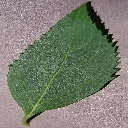

In [39]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0] 
pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/' + label)[pointer],
                            target_size= image_shape, color_mode='rgb')

print(f" Image shape: {pil_image.size}, Image mode: {pil_image.mode}")
pil_image

### Convert Image to Array and Prepare for Model Input

In [40]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0) / 255.0  
print(my_image.shape)

(1, 128, 128, 3)


### Predict class probabilities

In [41]:
pred_proba = model_mobilenet.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(f"{pred_class} {round(pred_proba*100, 2)}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Healthy 100.0%


## Complete Model Performance Report

In [42]:
import time
import pandas as pd
from IPython.display import display

# Record training duration
end_time = time.time()
training_time = round(end_time - start_time, 2)

# Extract accuracy metrics from training history
train_accuracy = round(history_mobilenet.history["accuracy"][-1], 4)
val_accuracy = round(history_mobilenet.history["val_accuracy"][-1], 4)

# Directly get test accuracy 
test_accuracy = (
    round(test_accuracy, 4) if isinstance(test_accuracy, (int, float)) else None
)

# Measure inference time
start_inf_time = time.time()
model_mobilenet.predict(my_image)  # Run prediction on a sample image
end_inf_time = time.time()

# Calculate inference time per image
inference_time = round((end_inf_time - start_inf_time), 4)

# Determine overfitting risk
overfitting_risk = "Yes" if train_accuracy - val_accuracy > 0.05 else "No"

# Store results in a structured format
results = {
    "Model": "MobileNetV2",
    "Training Accuracy": train_accuracy,
    "Validation Accuracy": val_accuracy,
    "Test Accuracy": test_accuracy,
    "Training Time (sec)": training_time,
    "Inference Time (sec/sample)": inference_time,
    "Batch Size": 16,
    "Overfitting Risk": overfitting_risk,
}

# Convert results into a DataFrame
df_results = pd.DataFrame([results])

# Save results to CSV (append mode)
csv_file = "training_results.csv"
df_results.to_csv(
    csv_file, mode="a", index=False, header=not pd.io.common.file_exists(csv_file)
)

# Display results as a table
display(df_results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Model  Training Accuracy  Validation Accuracy  Test Accuracy  \
0  MobileNetV2             0.9997                  1.0            1.0   

   Training Time (sec)  Inference Time (sec/sample)  Batch Size  \
0              1484.98                       0.1658          16   

  Overfitting Risk  
0               No

---

# Conclusion and Next Steps

---


We successfully developed a deep learning model for image classification using a structured, beginner-friendly approach.  

### **Key Achievements**
- **Explored Multiple Architectures** → Compared Sigmoid, Softmax, and MobileNetV2 across different trials.  
- **Comprehensive Evaluation** → Assessed models using accuracy, loss, confusion matrices, and ROC curves.  
- **Optimized for Generalization** → Selected the best-performing model with minimal overfitting.  
- **Deployment-Ready Model** → Finalized MobileNetV2 for real-world application.  

### **Next Steps: Model Deployment**
- **Web App Integration** → Implement a user-friendly Streamlit interface for real-time image classification.  
- **Model Deployment** → Load the trained model and deploy it on a cloud platform for accessibility.  

This deployment will enable efficient real-world usage, making automated classification accessible to users.  